<a href="https://colab.research.google.com/github/vishn96/Street-View-Housing-Number-Digit-Recognition/blob/main/Street_View_Housing_Number_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setting the current working directory
import os; os.chdir('drive/My Drive/PGP/Neural_Network')

In [3]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, h5py
import matplotlib.style as style; style.use('fivethirtyeight')
%matplotlib inline

# Metrics and preprocessing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# TF and Keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

# Checking if GPU is found
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.random.set_seed(42)

Found GPU at: /device:GPU:0


In [4]:
!ls '/content/drive/My Drive/PGP/Neural_Network'

SVHN_single_grey1.h5


In [5]:
# Read the h5 file
h5_SVH = h5py.File('SVHN_single_grey1.h5', 'r')

# Load the training, validation and test sets
X_train = h5_SVH['X_train'][:]
y_train_o = h5_SVH['y_train'][:]
X_val = h5_SVH['X_val'][:]
y_val_o = h5_SVH['y_val'][:]
X_test = h5_SVH['X_test'][:]
y_test_o = h5_SVH['y_test'][:]

# Close this file

h5_SVH.close()

print('Training set', X_train.shape, y_train_o.shape)
print('Validation set', X_val.shape, y_val_o.shape)
print('Test set', X_test.shape, y_test_o.shape)

print('\n')
print('Unique labels in y_train:', np.unique(y_train_o))
print('Unique labels in y_val:', np.unique(y_val_o))
print('Unique labels in y_test:', np.unique(y_test_o))

Training set (42000, 32, 32) (42000,)
Validation set (60000, 32, 32) (60000,)
Test set (18000, 32, 32) (18000,)


Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_val: [0 1 2 3 4 5 6 7 8 9]
Unique labels in y_test: [0 1 2 3 4 5 6 7 8 9]


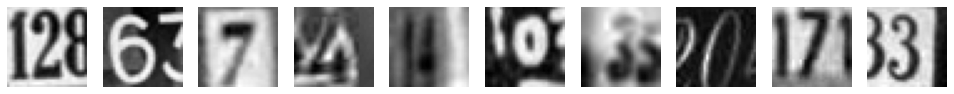

Label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [6]:
# Visualizing first 10 images in the dataset and their labels
plt.figure(figsize = (15, 4.5))
for i in range(10):  
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((32, 32)),cmap = plt.cm.binary)
    plt.axis('off')

plt.show()

print('Label for each of the above image: %s' % (y_train_o[0 : 10]))

Checking first image and label in training set
--------------------------------------------------------------------------------


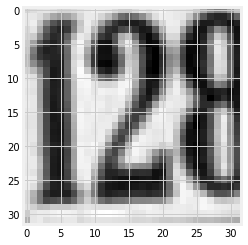

Label: 2
Checking first image and label in validation set
--------------------------------------------------------------------------------


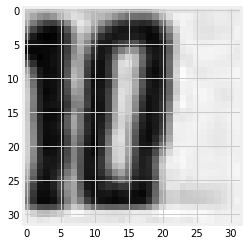

Label: 0
Checking first image and label in test set
--------------------------------------------------------------------------------


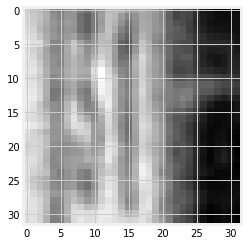

Label: 1


In [7]:
print('Checking first image and label in training set'); print('--'*40)
plt.imshow(X_train[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_train_o[0])

print('Checking first image and label in validation set'); print('--'*40)
plt.imshow(X_val[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_val_o[0])

print('Checking first image and label in test set'); print('--'*40)
plt.imshow(X_test[0], cmap = plt.cm.binary)    
plt.show()
print('Label:', y_test_o[0])

In [8]:
print('Reshaping X data: (n, 32, 32) => (n, 1024)'); print('--'*45)
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

print('Making sure that the values are float so that we can get decimal points after division'); print('--'*45)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('Normalizing the RGB codes by dividing it to the max RGB value'); print('--'*45)
X_train /= 255
X_val /= 255
X_test /= 255

print('Converting y data into categorical (one-hot encoding)'); print('--'*45)
y_train = to_categorical(y_train_o)
y_val = to_categorical(y_val_o)
y_test = to_categorical(y_test_o)

Reshaping X data: (n, 32, 32) => (n, 1024)
------------------------------------------------------------------------------------------
Making sure that the values are float so that we can get decimal points after division
------------------------------------------------------------------------------------------
Normalizing the RGB codes by dividing it to the max RGB value
------------------------------------------------------------------------------------------
Converting y data into categorical (one-hot encoding)
------------------------------------------------------------------------------------------


In [9]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

print('\n')
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

print('\n')
print('Number of images in X_train :', X_train.shape[0])
print('Number of images in X_val :', X_val.shape[0])
print('Number of images in X_test :', X_test.shape[0])

X_train shape: (42000, 1024)
X_val shape: (60000, 1024)
X_test shape: (18000, 1024)


y_train shape: (42000, 10)
y_val shape: (60000, 10)
y_test shape: (18000, 10)


Number of images in X_train : 42000
Number of images in X_val : 60000
Number of images in X_test : 18000


## **Modelling - Baby sitting the learning process**
**Fully connected linear layer**

In [10]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

**ReLU**

In [11]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

**Softmax function**

In [12]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

**Cross entropy loss** 

In [13]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

In [14]:
class NN():
    def __init__(self, lossfunc = CrossEntropy(), mode = 'train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

**Update function SGD with momentum**

In [15]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

**minibatches**

In [16]:
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

**training loop**

In [17]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu = 0.9, X_val = None, y_val = None, Lambda = 0, verb = True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

**Checking the accuracy of the model**

In [18]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

**Invoking all that we have created until now**

In [19]:
# Invoking the model
## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb = True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes1 = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes1))

    nn, val_acc = train(nn, X_train, y_train_o, minibatch_size = 200, epoch = iterations, learning_rate = learning_rate,\
                      X_val = X_test, y_val = y_test_o, Lambda = Lambda, verb = verb)
    return val_acc

**Double Check that the loss is reasonable : Disable the regularization**

In [20]:
lr = 0.00001
Lambda = 0
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.3075708433795503 | Training Accuracy = 0.09271428571428571


0.08855555555555555

**Now, lets crank up the Lambda(Regularization) and check what it does to our loss function**

In [21]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 2.3143311346047173 | Training Accuracy = 0.10983333333333334


0.11016666666666666

**Now, lets overfit to a small subset of our dataset, in this case 20 images**

In [22]:
X_train_subset = X_train[0:20]
y_train_subset = y_train_o[0:20]

X_train = X_train_subset
y_train_o = y_train_subset

X_train.shape, y_train_o.shape

((20, 1024), (20,))

**Make sure that you can overfit very small portion of the training data**

So, set a small learning rate and turn regularization off In the code below:

*   Take the first 20 examples
*   turn off regularization(reg=0.0)
*   use simple vanilla 'sgd'


In [23]:
%time
lr = 0.001
Lambda = 0
train_and_test_loop(5000, lr, Lambda)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs
Epoch 0/5000: Loss = 2.3376287833056706 | Training Accuracy = 0.1
Epoch 50/5000: Loss = 1.9429845985995438 | Training Accuracy = 0.3
Epoch 100/5000: Loss = 1.858145742182116 | Training Accuracy = 0.3
Epoch 150/5000: Loss = 1.8043437499365211 | Training Accuracy = 0.45
Epoch 200/5000: Loss = 1.7595187449974894 | Training Accuracy = 0.45
Epoch 250/5000: Loss = 1.719100326717852 | Training Accuracy = 0.45
Epoch 300/5000: Loss = 1.6814856488300904 | Training Accuracy = 0.5
Epoch 350/5000: Loss = 1.645942736662724 | Training Accuracy = 0.55
Epoch 400/5000: Loss = 1.612078995884033 | Training Accuracy = 0.55
Epoch 450/5000: Loss = 1.5796567552770582 | Training Accuracy = 0.55
Epoch 500/5000: Loss = 1.5485168703241747 | Training Accuracy = 0.6
Epoch 550/5000: Loss = 1.51854349863012 | Training Accuracy = 0.6
Epoch 600/5000: Loss = 1.4896465469738382 | Training Accuracy = 0.6
Epoch 650/5000: Loss = 1.461752335669504 | Training Acc

0.13694444444444445

**Loading the original dataset again**

In [24]:

h5_SVH = h5py.File('SVHN_single_grey1.h5', 'r')
# Load the training, validation and test sets
X_train = h5_SVH['X_train'][:]
y_train_o = h5_SVH['y_train'][:]
X_val = h5_SVH['X_val'][:]
y_val_o = h5_SVH['y_val'][:]
X_test = h5_SVH['X_test'][:]
y_test_o = h5_SVH['y_test'][:]

print('Reshaping X data: (n, 32, 32) => (n, 1024)'); print('--'*40)
X_train = X_train.reshape((X_train.shape[0], -1))
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

print('Making sure that the values are float so that we can get decimal points after division'); print('--'*40)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('Normalizing the RGB codes by dividing it to the max RGB value'); print('--'*40)
X_train /= 255
X_val /= 255
X_test /= 255

print('Converting y data into categorical (one-hot encoding)'); print('--'*40)
y_train = to_categorical(y_train_o)
y_val = to_categorical(y_val_o)
y_test = to_categorical(y_test_o)

Reshaping X data: (n, 32, 32) => (n, 1024)
--------------------------------------------------------------------------------
Making sure that the values are float so that we can get decimal points after division
--------------------------------------------------------------------------------
Normalizing the RGB codes by dividing it to the max RGB value
--------------------------------------------------------------------------------
Converting y data into categorical (one-hot encoding)
--------------------------------------------------------------------------------


**Start with small regularization and find learning rate that makes the loss go down.**

*   we start with Lambda(small regularization) = 1e-7
*   we start with a small learning rate = 1e-7

In [25]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.313430385002409 | Training Accuracy = 0.10026190476190476
Epoch 50/500: Loss = 2.30966525334014 | Training Accuracy = 0.10042857142857142
Epoch 100/500: Loss = 2.307249386713144 | Training Accuracy = 0.10154761904761905
Epoch 150/500: Loss = 2.305690386678784 | Training Accuracy = 0.10264285714285715
Epoch 200/500: Loss = 2.3046794984921735 | Training Accuracy = 0.10302380952380952
Epoch 250/500: Loss = 2.3040206632550184 | Training Accuracy = 0.10376190476190476
Epoch 300/500: Loss = 2.303588469207817 | Training Accuracy = 0.10497619047619047
Epoch 350/500: Loss = 2.303302365026004 | Training Accuracy = 0.10688095238095238
Epoch 400/500: Loss = 2.303110498199185 | Training Accuracy = 0.10819047619047618
Epoch 450/500: Loss = 2.30297945188193 | Training Accuracy = 0.10842857142857143


0.10722222222222222

**Lets try to train now with a value of learning rate 0.001**

In [26]:
lr = 0.001
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3043172853088545 | Training Accuracy = 0.11697619047619047
Epoch 50/500: Loss = 2.259137893639948 | Training Accuracy = 0.21214285714285713
Epoch 100/500: Loss = 2.2506358493130385 | Training Accuracy = 0.22083333333333333
Epoch 150/500: Loss = 2.246322320436922 | Training Accuracy = 0.22652380952380952
Epoch 200/500: Loss = 2.243437872527246 | Training Accuracy = 0.2288095238095238
Epoch 250/500: Loss = 2.241269179951821 | Training Accuracy = 0.22990476190476192
Epoch 300/500: Loss = 2.2395311747584348 | Training Accuracy = 0.2317857142857143
Epoch 350/500: Loss = 2.238080495399565 | Training Accuracy = 0.23338095238095238
Epoch 400/500: Loss = 2.236834647672908 | Training Accuracy = 0.23438095238095238
Epoch 450/500: Loss = 2.2357418364572332 | Training Accuracy = 0.23561904761904762


0.21777777777777776

**Hyperparameter Optimization**

**Running a finer search**

In [27]:
import math
for k in range(1, 10):
    lr = math.pow(10, np.random.uniform(-3.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5, 2))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 10, best_acc, lr, Lambda))

Try 1/10: Best_val_acc: 0.18594444444444444, lr: 0.0022445486695815554, Lambda: 4.468938038777701

Try 2/10: Best_val_acc: 0.19394444444444445, lr: 0.0043192340925826194, Lambda: 3.265320449954064e-05

Try 3/10: Best_val_acc: 0.19777777777777777, lr: 0.0011061360864759757, Lambda: 0.0022397801458532026

Try 4/10: Best_val_acc: 0.20333333333333334, lr: 0.001846001016682408, Lambda: 11.143539156195237

Try 5/10: Best_val_acc: 0.1935, lr: 0.0019245785424494785, Lambda: 5.8151293567523365e-05

Try 6/10: Best_val_acc: 0.2078888888888889, lr: 0.0013219046416681544, Lambda: 3.5214253685826065

Try 7/10: Best_val_acc: 0.2003888888888889, lr: 0.007110008628874481, Lambda: 0.8635572757207823

Try 8/10: Best_val_acc: 0.2055, lr: 0.0012479182008206348, Lambda: 0.05217066718973961

Try 9/10: Best_val_acc: 0.18855555555555556, lr: 0.0033892661998016363, Lambda: 0.0009983402985581941



Observation 2 - Baby sitting the neural network for SVHN
Best accuracy achieved using this method after hyperparameter optimization: 21%.

**Modelling - Neural Network API**

**NN model, sigmoid activations, SGD optimizer**

In [28]:
print('NN model with sigmoid activations'); print('--'*40)
# Initialize the neural network classifier
model1 = Sequential()

# Input Layer - adding input layer and activation functions sigmoid
model1.add(Dense(128, input_shape = (1024, )))
# Adding activation function
model1.add(Activation('sigmoid'))

#Hidden Layer 1 - adding first hidden layer
model1.add(Dense(64))
# Adding activation function
model1.add(Activation('sigmoid'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model1.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model1.add(Activation('softmax'))

NN model with sigmoid activations
--------------------------------------------------------------------------------


In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 140,106
Trainable params: 140,106
Non-trainable params: 0
__________________________________________________

In [30]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model1.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 3s 6ms/step - loss: 2.3709 - accuracy: 0.0996 - val_loss: 2.3028 - val_accuracy: 0.1001
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 2.3029 - accuracy: 0.0976 - val_loss: 2.3028 - val_accuracy: 0.1007
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 2.3028 - accuracy: 0.1001 - val_loss: 2.3025 - val_accuracy: 0.1059
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 2.3025 - accuracy: 0.1052 - val_loss: 2.3025 - val_accuracy: 0.1060
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 2.3025 - accuracy: 0.1024 - val_loss: 2.3024 - val_accuracy: 0.1010
Epoch 6/100
210/210 [==============================] - 1s 5ms/step - loss: 2.3024 - accuracy: 0.1043 - val_loss: 2.3025 - val_accuracy: 0.1017
Epoch 7/100
210/210 [==============================] - 1s 5ms/step - loss: 2.3024 - accuracy: 0.1060 - val_loss: 2.3024 - val_accuracy: 0.1058

In [31]:
print('Evaluate NN model with sigmoid activations'); print('--'*40)
results1 = model1.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results1[1]*100, 2), '%'))

Evaluate NN model with sigmoid activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2987 - accuracy: 0.1412
Validation accuracy: 14.12


**NN model, sigmoid activations, SGD optimizer, changing learning rate**

In [32]:
print('NN model with sigmoid activations - changing learning rate'); print('--'*40)
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.001)
model1.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

NN model with sigmoid activations - changing learning rate
--------------------------------------------------------------------------------
Epoch 1/100
210/210 [==============================] - 1s 6ms/step - loss: 2.2988 - accuracy: 0.1411 - val_loss: 2.2986 - val_accuracy: 0.1469
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2984 - accuracy: 0.1538 - val_loss: 2.2986 - val_accuracy: 0.1489
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2982 - accuracy: 0.1492 - val_loss: 2.2986 - val_accuracy: 0.1486
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2984 - accuracy: 0.1522 - val_loss: 2.2986 - val_accuracy: 0.1478
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2984 - accuracy: 0.1471 - val_loss: 2.2986 - val_accuracy: 0.1478
Epoch 6/100
210/210 [==============================] - 1s 6ms/step - loss: 2.2984 - accuracy: 0.1530 - val_loss: 2.2986 - val_accuracy: 0.1477
Ep

In [33]:
print('Evaluate NN model with sigmoid activations - changing learning rate'); print('--'*40)
results1 = model1.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results1[1]*100, 2), '%'))

Evaluate NN model with sigmoid activations - changing learning rate
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2982 - accuracy: 0.1508
Validation accuracy: 15.08


**Observation 3 - NN model with sigmoid activations**

*   Validation score is very low, changing learning rate further reduces it.
*   Optimizing the network in order to better learn the patterns in the dataset.
*   Best model out of the above is the one with lower learning rate using SGD optimizer and sigmoid activations. 
*   Next, let's use relu activations and see if the score improves.



**NN model, relu activations, SGD optimizer**

In [34]:
%time
print('NN model with relu activations and sgd optimizers'); print('--'*40)
# Initialize the neural network classifier
model2 = Sequential()

# Input Layer - adding input layer and activation functions relu
model2.add(Dense(128, input_shape = (1024, )))
# Adding activation function
model2.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model2.add(Dense(64))
# Adding activation function
model2.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model2.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model2.add(Activation('softmax'))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
NN model with relu activations and sgd optimizers
--------------------------------------------------------------------------------


In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 140,106
Trainable params: 140,106
Non-trainable params: 0
________________________________________________

In [36]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model2.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 2.3101 - accuracy: 0.1155 - val_loss: 2.2903 - val_accuracy: 0.1455
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2879 - accuracy: 0.1492 - val_loss: 2.2813 - val_accuracy: 0.1431
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2770 - accuracy: 0.1656 - val_loss: 2.2672 - val_accuracy: 0.1981
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2655 - accuracy: 0.1926 - val_loss: 2.2535 - val_accuracy: 0.2119
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2501 - accuracy: 0.2132 - val_loss: 2.2360 - val_accuracy: 0.2342
Epoch 6/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2305 - accuracy: 0.2531 - val_loss: 2.2134 - val_accuracy: 0.2679
Epoch 7/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2081 - accuracy: 0.2650 - val_loss: 2.1887 - val_accuracy: 0.2767

In [37]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7212 - accuracy: 0.7904
Validation accuracy: 79.04


**NN model, relu activations, SGD optimizer, changing learning rate**


In [38]:
%time
print('NN model with relu activations and sgd optimizers - changing learning rate'); print('--'*40)
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.001)
model2.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
NN model with relu activations and sgd optimizers - changing learning rate
--------------------------------------------------------------------------------
Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 0.6588 - accuracy: 0.8101 - val_loss: 0.6859 - val_accuracy: 0.8011
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6641 - accuracy: 0.8064 - val_loss: 0.6858 - val_accuracy: 0.8019
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6659 - accuracy: 0.8082 - val_loss: 0.6846 - val_accuracy: 0.8015
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6704 - accuracy: 0.8057 - val_loss: 0.6845 - val_accuracy: 0.8025
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6591 - accuracy: 0.8094 - val_loss: 0.6836 - val_accuracy: 0.8030
Epoch 6/100
210/210 [==============================] - 1s 5ms/ste

In [39]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6523 - accuracy: 0.8121
Validation accuracy: 81.21


**NN model, relu activations, adam optimizer**

In [40]:
%time
print('NN model with relu activations and adam optimizer'); print('--'*40)
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.01)
model2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
NN model with relu activations and adam optimizer
--------------------------------------------------------------------------------
Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 6.9578 - accuracy: 0.1306 - val_loss: 2.2255 - val_accuracy: 0.1825
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 2.1936 - accuracy: 0.1858 - val_loss: 2.0508 - val_accuracy: 0.2329
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 1.9863 - accuracy: 0.2703 - val_loss: 1.8088 - val_accuracy: 0.3566
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 1.6383 - accuracy: 0.4418 - val_loss: 1.4876 - val_accuracy: 0.4878
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 1.4055 - accuracy: 0.5370 - val_loss: 1.3395 - val_accuracy: 0.5571
Epoch 6/100
210/210 [==============================] - 1s 5ms/step - loss: 1.2978 - accura

In [41]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.8203 - accuracy: 0.7560
Validation accuracy: 75.6


**NN model, relu activations, adam optimizer, changing learning rate**

In [42]:
%time
print('NN model with relu activations and adam optimizer'); print('--'*40)
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
NN model with relu activations and adam optimizer
--------------------------------------------------------------------------------
Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 0.7230 - accuracy: 0.7810 - val_loss: 0.7481 - val_accuracy: 0.7775
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 0.7087 - accuracy: 0.7837 - val_loss: 0.7564 - val_accuracy: 0.7740
Epoch 3/100
210/210 [==============================] - 1s 6ms/step - loss: 0.7142 - accuracy: 0.7838 - val_loss: 0.7378 - val_accuracy: 0.7789
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 0.7098 - accuracy: 0.7845 - val_loss: 0.7536 - val_accuracy: 0.7745
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 0.7060 - accuracy: 0.7857 - val_loss: 0.7439 - val_accuracy: 0.7779
Epoch 6/100
210/210 [==============================] - 1s 6ms/step - loss: 0.7103 - accura

In [43]:
print('Evaluate NN model with relu activations'); print('--'*40)
results2 = model2.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results2[1]*100, 2), '%'))

Evaluate NN model with relu activations
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7048 - accuracy: 0.7902
Validation accuracy: 79.02


**Observation 4 - NN model with relu activations**

*   Best accuracy achieved till now is using relu activations, SGD optimizer, changing learning rate to 0.001.
*   Improves the scores considerably.
*  Next, let's try and change the number of activators and see if the score improves.


**NN model, relu activations, changing number of activators, SGD optimizers**

In [44]:
print('NN model with relu activations and changing number of activators'); print('--'*40)
# Initialize the neural network classifier
model3 = Sequential()

# Input Layer - adding input layer and activation functions relu
model3.add(Dense(256, input_shape = (1024, )))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model3.add(Dense(128))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 2 - Adding second hidden layer
model3.add(Dense(64))
# Adding activation function
model3.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model3.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model3.add(Activation('softmax'))

NN model with relu activations and changing number of activators
--------------------------------------------------------------------------------


In [45]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_8 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [46]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model3.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 2.3083 - accuracy: 0.0986 - val_loss: 2.2938 - val_accuracy: 0.1208
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2910 - accuracy: 0.1301 - val_loss: 2.2824 - val_accuracy: 0.1472
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2795 - accuracy: 0.1609 - val_loss: 2.2685 - val_accuracy: 0.1941
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2653 - accuracy: 0.1973 - val_loss: 2.2517 - val_accuracy: 0.2176
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2461 - accuracy: 0.2218 - val_loss: 2.2280 - val_accuracy: 0.2630
Epoch 6/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2211 - accuracy: 0.2657 - val_loss: 2.1943 - val_accuracy: 0.2930
Epoch 7/100
210/210 [==============================] - 1s 5ms/step - loss: 2.1846 - accuracy: 0.3036 - val_loss: 2.1501 - val_accuracy: 0.2870

In [47]:
print('Evaluate NN model with relu activations and changing the number of activators'); print('--'*40)
results3 = model3.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results3[1]*100, 2), '%'))

Evaluate NN model with relu activations and changing the number of activators
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6066 - accuracy: 0.8211
Validation accuracy: 82.11


**NN model, relu activations, changing number of activators, Adam optimizers**

In [48]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model3.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 7ms/step - loss: 1.2363 - accuracy: 0.6563 - val_loss: 0.8057 - val_accuracy: 0.7567
Epoch 2/100
210/210 [==============================] - 1s 6ms/step - loss: 0.7625 - accuracy: 0.7646 - val_loss: 0.7506 - val_accuracy: 0.7735
Epoch 3/100
210/210 [==============================] - 1s 6ms/step - loss: 0.7313 - accuracy: 0.7765 - val_loss: 0.6977 - val_accuracy: 0.7866
Epoch 4/100
210/210 [==============================] - 1s 6ms/step - loss: 0.7233 - accuracy: 0.7783 - val_loss: 0.6797 - val_accuracy: 0.7966
Epoch 5/100
210/210 [==============================] - 1s 6ms/step - loss: 0.7002 - accuracy: 0.7854 - val_loss: 0.7305 - val_accuracy: 0.7774
Epoch 6/100
210/210 [==============================] - 1s 6ms/step - loss: 0.6964 - accuracy: 0.7848 - val_loss: 0.6891 - val_accuracy: 0.7909
Epoch 7/100
210/210 [==============================] - 1s 6ms/step - loss: 0.6949 - accuracy: 0.7903 - val_loss: 0.6886 - val_accuracy: 0.7910

**Observation 5 - NN model with relu activations and changing activators**

Adding relu activations and changing activators results in improvement of score.
Best accuracy achieved till now is using relu activations, changing number of activators and Adam optimizers with a learning rate of 0.001
Next, let's try adding weight initilization.

**With Weight Initializers**

Changing weight initialization scheme can significantly improve training of the model by preventing vanishing gradient problem up to some degree.

**NN model, relu activations, SGD optimizers with weight initializers**

In [49]:
print('NN model with weight initializers'); print('--'*40)
# Initialize the neural network classifier
model4 = Sequential()

# Input Layer - adding input layer and activation functions relu and weight initializer
model4.add(Dense(256, input_shape = (1024, ), kernel_initializer = 'he_normal'))
# Adding activation function
model4.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model4.add(Dense(128, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('relu'))

#Hidden Layer 2 - adding second hidden layer
model4.add(Dense(64, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('relu'))

#Hidden Layer 3 - adding third hidden layer
model4.add(Dense(32, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model4.add(Dense(10, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model4.add(Activation('softmax'))

NN model with weight initializers
--------------------------------------------------------------------------------


In [50]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_11 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_12 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

In [51]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
# Adding activation function - softmax for multiclass classification
model4.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model4.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 2.3359 - accuracy: 0.1080 - val_loss: 2.2874 - val_accuracy: 0.1453
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2800 - accuracy: 0.1571 - val_loss: 2.2537 - val_accuracy: 0.1787
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 2.2392 - accuracy: 0.1918 - val_loss: 2.1926 - val_accuracy: 0.2271
Epoch 4/100
210/210 [==============================] - 1s 6ms/step - loss: 2.1764 - accuracy: 0.2411 - val_loss: 2.1094 - val_accuracy: 0.2932
Epoch 5/100
210/210 [==============================] - 1s 6ms/step - loss: 2.0844 - accuracy: 0.2944 - val_loss: 1.9983 - val_accuracy: 0.3119
Epoch 6/100
210/210 [==============================] - 1s 5ms/step - loss: 1.9681 - accuracy: 0.3413 - val_loss: 1.8691 - val_accuracy: 0.3757
Epoch 7/100
210/210 [==============================] - 1s 6ms/step - loss: 1.8496 - accuracy: 0.3807 - val_loss: 1.7729 - val_accuracy: 0.3992

In [52]:
print('NN with weight initializers'); print('--'*40)
results4 = model4.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results4[1]*100, 2), '%'))

NN with weight initializers
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5375 - accuracy: 0.8407
Validation accuracy: 84.07


**NN model, relu activations, Adam optimizers with weight initializers**

In [53]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
# Adding activation function - softmax for multiclass classification
model4.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model4.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 1.2476 - accuracy: 0.6644 - val_loss: 0.7288 - val_accuracy: 0.7766
Epoch 2/100
210/210 [==============================] - 1s 5ms/step - loss: 0.7319 - accuracy: 0.7735 - val_loss: 0.8146 - val_accuracy: 0.7491
Epoch 3/100
210/210 [==============================] - 1s 5ms/step - loss: 0.7228 - accuracy: 0.7735 - val_loss: 0.7179 - val_accuracy: 0.7834
Epoch 4/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6873 - accuracy: 0.7890 - val_loss: 0.7213 - val_accuracy: 0.7815
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6871 - accuracy: 0.7886 - val_loss: 0.7225 - val_accuracy: 0.7759
Epoch 6/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6855 - accuracy: 0.7878 - val_loss: 0.6291 - val_accuracy: 0.8106
Epoch 7/100
210/210 [==============================] - 1s 5ms/step - loss: 0.6708 - accuracy: 0.7952 - val_loss: 0.6667 - val_accuracy: 0.7928

In [54]:
print('NN with weight initializers'); print('--'*40)
results4 = model4.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results4[1]*100, 2), '%'))

NN with weight initializers
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3546 - accuracy: 0.9046
Validation accuracy: 90.46


**Observation 6 - Weight initializers**
Adding weight initialiers didn't result in improvement of score.
relu activations, changing number of activators, Adam optimizers gives the best score out of the ones tried as of now.
Next, let's try batch normalization.

**Batch Normalization**
Batch Normalization, one of the methods to prevent the "internal covariance shift" problem, has proven to be highly effective. Normalize each mini-batch before nonlinearity.

**NN model, relu activations, SGD optimizers with weight initializers and batch normalization**

In [55]:
print('NN model with batch normalization'); print('--'*40)
# Initialize the neural network classifier
model5 = Sequential()

# Input Layer - adding input layer and activation functions relu and weight initializer
model5.add(Dense(256, input_shape = (1024, ), kernel_initializer = 'he_normal'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model5.add(Dense(128, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

#Hidden Layer 2 - adding second hidden layer
model5.add(Dense(64, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

#Hidden Layer 3 - adding third hidden layer
model5.add(Dense(32, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model5.add(BatchNormalization())
# Adding activation function
model5.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model5.add(Dense(10, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding activation function
model5.add(Activation('softmax'))

NN model with batch normalization
--------------------------------------------------------------------------------


In [56]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_16 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [57]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
# Adding activation function - softmax for multiclass classification
model5.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model5.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 8ms/step - loss: 2.5127 - accuracy: 0.1414 - val_loss: 2.2163 - val_accuracy: 0.1946
Epoch 2/100
210/210 [==============================] - 1s 7ms/step - loss: 1.9609 - accuracy: 0.3325 - val_loss: 1.8471 - val_accuracy: 0.3794
Epoch 3/100
210/210 [==============================] - 1s 7ms/step - loss: 1.6684 - accuracy: 0.4704 - val_loss: 1.5840 - val_accuracy: 0.4962
Epoch 4/100
210/210 [==============================] - 1s 6ms/step - loss: 1.4676 - accuracy: 0.5481 - val_loss: 1.4100 - val_accuracy: 0.5626
Epoch 5/100
210/210 [==============================] - 2s 8ms/step - loss: 1.3040 - accuracy: 0.6026 - val_loss: 1.2984 - val_accuracy: 0.5990
Epoch 6/100
210/210 [==============================] - 2s 7ms/step - loss: 1.1861 - accuracy: 0.6419 - val_loss: 1.1701 - val_accuracy: 0.6413
Epoch 7/100
210/210 [==============================] - 2s 7ms/step - loss: 1.0795 - accuracy: 0.6764 - val_loss: 1.1238 - val_accuracy: 0.6569

In [58]:
print('NN with batch normalization'); print('--'*40)
results5 = model5.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results5[1]*100, 2), '%'))

NN with batch normalization
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7282 - accuracy: 0.8030
Validation accuracy: 80.3


**NN model, relu activations, Adam optimizers with weight initializers and batch normalization**

In [59]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
# Adding activation function - softmax for multiclass classification
model5.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model5.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 8ms/step - loss: 0.8943 - accuracy: 0.7473 - val_loss: 2.0959 - val_accuracy: 0.4600
Epoch 2/100
210/210 [==============================] - 2s 7ms/step - loss: 0.5799 - accuracy: 0.8148 - val_loss: 1.5290 - val_accuracy: 0.5096
Epoch 3/100
210/210 [==============================] - 2s 8ms/step - loss: 0.5020 - accuracy: 0.8380 - val_loss: 1.8730 - val_accuracy: 0.4971
Epoch 4/100
210/210 [==============================] - 1s 7ms/step - loss: 0.4657 - accuracy: 0.8488 - val_loss: 1.1412 - val_accuracy: 0.6554
Epoch 5/100
210/210 [==============================] - 1s 7ms/step - loss: 0.4327 - accuracy: 0.8605 - val_loss: 1.2379 - val_accuracy: 0.6293
Epoch 6/100
210/210 [==============================] - 1s 7ms/step - loss: 0.4330 - accuracy: 0.8605 - val_loss: 1.1713 - val_accuracy: 0.6431
Epoch 7/100
210/210 [==============================] - 1s 7ms/step - loss: 0.4137 - accuracy: 0.8666 - val_loss: 1.1813 - val_accuracy: 0.6318

In [60]:
print('NN with batch normalization'); print('--'*40)
results5 = model5.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results5[1]*100, 2), '%'))

NN with batch normalization
--------------------------------------------------------------------------------
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7427 - accuracy: 0.8327
Validation accuracy: 83.27


**Observation 7 - Batch Normalization**
Batch normalization didn't result in improvement of score.
Relu activations, changing number of activators, Adam optimizers achieved the best score.
Next, let's try batch normalization with dropout.

**Dropout**
**NN model, relu activations, SGD optimizers with weight initializers, batch normalization and dropout**

In [61]:
print('NN model with dropout - sgd optimizer'); print('--'*40)
# Initialize the neural network classifier
model6 = Sequential()
# Input Layer - adding input layer and activation functions relu and weight initializer
model6.add(Dense(512, input_shape = (1024, ), kernel_initializer = 'he_normal'))
# Adding batch normalization
model6.add(BatchNormalization()) 
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 1 - adding first hidden layer
model6.add(Dense(256, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 2 - adding second hidden layer
model6.add(Dense(128, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 3 - adding third hidden layer
model6.add(Dense(64, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

#Hidden Layer 4 - adding fourth hidden layer
model6.add(Dense(32, kernel_initializer = 'he_normal', bias_initializer = 'he_uniform'))
# Adding batch normalization
model6.add(BatchNormalization())
# Adding activation function
model6.add(Activation('relu'))
# Adding dropout layer
model6.add(Dropout(0.2))

# Output Layer - adding output layer which is of 10 nodes (digits)
model6.add(Dense(10, kernel_initializer = 'he_normal',bias_initializer = 'he_uniform'))
# Adding activation function
model6.add(Activation('softmax'))

NN model with dropout - sgd optimizer
--------------------------------------------------------------------------------


In [62]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
activation_20 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_21 (Activation)   (None, 256)              

In [63]:
# compiling the neural network classifier, sgd optimizer
sgd = optimizers.SGD(lr = 0.01)
model6.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Adding activation function - softmax for multiclass classification
history = model6.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 3s 9ms/step - loss: 2.6774 - accuracy: 0.1028 - val_loss: 2.3048 - val_accuracy: 0.1145
Epoch 2/100
210/210 [==============================] - 2s 8ms/step - loss: 2.4614 - accuracy: 0.1233 - val_loss: 2.2240 - val_accuracy: 0.1836
Epoch 3/100
210/210 [==============================] - 2s 8ms/step - loss: 2.3604 - accuracy: 0.1444 - val_loss: 2.1569 - val_accuracy: 0.2304
Epoch 4/100
210/210 [==============================] - 2s 8ms/step - loss: 2.2676 - accuracy: 0.1744 - val_loss: 2.0482 - val_accuracy: 0.2909
Epoch 5/100
210/210 [==============================] - 2s 7ms/step - loss: 2.1910 - accuracy: 0.2015 - val_loss: 1.9662 - val_accuracy: 0.3325
Epoch 6/100
210/210 [==============================] - 2s 8ms/step - loss: 2.1103 - accuracy: 0.2355 - val_loss: 1.8594 - val_accuracy: 0.3747
Epoch 7/100
210/210 [==============================] - 1s 7ms/step - loss: 2.0304 - accuracy: 0.2676 - val_loss: 1.7758 - val_accuracy: 0.4079

In [64]:
print('NN model with dropout - sgd optimizer'); print('--'*40)
results6 = model6.evaluate(X_val, y_val)
print('Validation accuracy: {}'.format(round(results6[1]*100, 2), '%'))

NN model with dropout - sgd optimizer
--------------------------------------------------------------------------------
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4882 - accuracy: 0.8527
Validation accuracy: 85.27


In [65]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model6.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Adding activation function - softmax for multiclass classification
history = model6.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 3s 8ms/step - loss: 1.1192 - accuracy: 0.6540 - val_loss: 1.4036 - val_accuracy: 0.5228
Epoch 2/100
210/210 [==============================] - 2s 7ms/step - loss: 0.9152 - accuracy: 0.7142 - val_loss: 1.0832 - val_accuracy: 0.6567
Epoch 3/100
210/210 [==============================] - 2s 7ms/step - loss: 0.8435 - accuracy: 0.7404 - val_loss: 1.4289 - val_accuracy: 0.5132
Epoch 4/100
210/210 [==============================] - 2s 8ms/step - loss: 0.8042 - accuracy: 0.7563 - val_loss: 1.0426 - val_accuracy: 0.6532
Epoch 5/100
210/210 [==============================] - 2s 8ms/step - loss: 0.7599 - accuracy: 0.7674 - val_loss: 1.5779 - val_accuracy: 0.5092
Epoch 6/100
210/210 [==============================] - 2s 8ms/step - loss: 0.7407 - accuracy: 0.7754 - val_loss: 0.8996 - val_accuracy: 0.7060
Epoch 7/100
210/210 [==============================] - 2s 9ms/step - loss: 0.7141 - accuracy: 0.7838 - val_loss: 0.9838 - val_accuracy: 0.6737

**Observation 8 - Batch Normalization and Dropout**
Didn't result in any improvement of score.
NN model, relu activations, SGD optimizers with weight initializers and batch normalization is still the best model.
Next, let's try batch normalization and dropout with adam optimizer.

**Prediction on test dataset using Model 3 - relu activations, Adam optimizers**

In [66]:

print('NN model with relu activations and changing number of activators'); print('--'*40)
# Initialize the neural network classifier
model3 = Sequential()

# Input Layer - adding input layer and activation functions relu
model3.add(Dense(256, input_shape = (1024, )))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 1 - adding first hidden layer
model3.add(Dense(128))
# Adding activation function
model3.add(Activation('relu'))

#Hidden Layer 2 - Adding second hidden layer
model3.add(Dense(64))
# Adding activation function
model3.add(Activation('relu'))

# Output Layer - adding output layer which is of 10 nodes (digits)
model3.add(Dense(10))
# Adding activation function - softmax for multiclass classification
model3.add(Activation('softmax'))

NN model with relu activations and changing number of activators
--------------------------------------------------------------------------------


In [67]:
# compiling the neural network classifier, adam optimizer
adam = optimizers.Adam(lr = 0.001)
model3.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Fitting the neural network for training
history = model3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 200, epochs = 100, verbose = 1)

Epoch 1/100
210/210 [==============================] - 2s 6ms/step - loss: 2.3062 - accuracy: 0.1075 - val_loss: 2.1099 - val_accuracy: 0.1809
Epoch 2/100
210/210 [==============================] - 1s 6ms/step - loss: 1.9415 - accuracy: 0.2953 - val_loss: 1.5750 - val_accuracy: 0.4786
Epoch 3/100
210/210 [==============================] - 1s 6ms/step - loss: 1.4597 - accuracy: 0.5189 - val_loss: 1.2618 - val_accuracy: 0.6003
Epoch 4/100
210/210 [==============================] - 1s 6ms/step - loss: 1.2437 - accuracy: 0.6056 - val_loss: 1.1368 - val_accuracy: 0.6423
Epoch 5/100
210/210 [==============================] - 1s 5ms/step - loss: 1.1378 - accuracy: 0.6415 - val_loss: 1.0664 - val_accuracy: 0.6693
Epoch 6/100
210/210 [==============================] - 1s 5ms/step - loss: 1.0761 - accuracy: 0.6616 - val_loss: 1.0348 - val_accuracy: 0.6758
Epoch 7/100
210/210 [==============================] - 1s 5ms/step - loss: 1.0178 - accuracy: 0.6855 - val_loss: 0.9505 - val_accuracy: 0.7078

In [68]:
print('Testing the model on test dataset')
predictions = model3.predict_classes(X_test)
score = model3.evaluate(X_test, y_test)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Testing the model on test dataset


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


563/563 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.8302
Test loss : 0.6745544672012329
Test accuracy : 0.8302222490310669


In [69]:
print('Classification Report'); print('--'*40)
print(classification_report(y_test_o, predictions))

Classification Report
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1814
           1       0.83      0.85      0.84      1828
           2       0.91      0.81      0.86      1803
           3       0.78      0.79      0.78      1719
           4       0.85      0.87      0.86      1812
           5       0.81      0.82      0.81      1768
           6       0.85      0.82      0.84      1832
           7       0.84      0.89      0.86      1808
           8       0.77      0.80      0.78      1812
           9       0.85      0.77      0.81      1804

    accuracy                           0.83     18000
   macro avg       0.83      0.83      0.83     18000
weighted avg       0.83      0.83      0.83     18000



Visualizing the confusion matrix


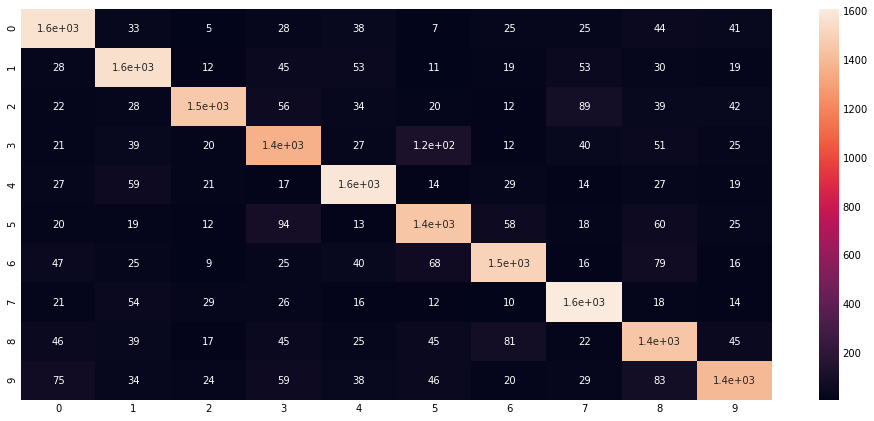

In [70]:
print('Visualizing the confusion matrix')
plt.figure(figsize = (15, 7.2))
sns.heatmap(confusion_matrix(y_test_o, predictions), annot = True)

In [74]:
history.describe()

AttributeError: ignored

In [79]:
model3.predict_classes(X_test)[5]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


9

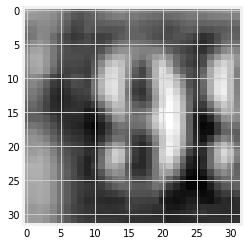

In [82]:
#Showing the image
plt.imshow(X_test[5].reshape(32, 32), cmap = 'gray')

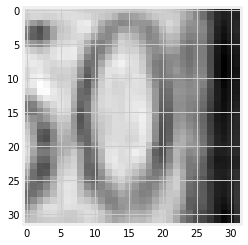

In [80]:
#Showing the image
plt.imshow(X_test[20].reshape(32, 32), cmap = 'gray')

In [81]:
model3.predict_classes(X_test)[20]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0

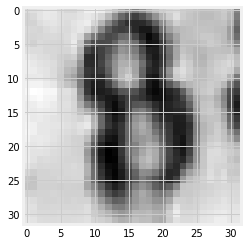

In [83]:
plt.imshow(X_test[10].reshape(32, 32), cmap = 'gray')

In [84]:
model3.predict_classes(X_test)[10]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8

**Conclusion**
Evaluated the accuracy using two methods i.e. baby sitting the NN and NN through API. Followed all the required steps starting with loading the datasets to performing hyperparameter optimization and running a finer search by using a finer range. Explored different options in optimizers, number of activators, learning rate and activation methods in NN through API. Found that baby sitting process achieved the best accuracy of 21% using hyper parameter optimization. It might have been further improved but that's the trade off vs time taken to run the script. NN through API method achieved best accuracy of 90% on validation set. Also printed the classification report, visualized the confusion matrix and summarized history for accuracy and loss.